In [1]:
import torch

In [2]:
import torch
import torch.nn as nn
import numpy as np
import time
import math
from matplotlib import pyplot

torch.manual_seed(0)
np.random.seed(0)

# This concept is also called teacher forceing. 
# The flag decides if the loss will be calculted over all 
# or just the predicted values.
calculate_loss_over_all_values = False

In [3]:
input_window = 100
output_window = 5
batch_size = 32 # batch size
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = ("cpu")

In [4]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()       
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        
        #pe.requires_grad = False
        self.register_buffer('pe', pe)

    def forward(self, x):

        return x + self.pe[:x.size(0), :]

In [5]:
class TransAm(nn.Module):
    def __init__(self,feature_size=10, num_layers=3, dropout=0.1):
        super(TransAm, self).__init__()
        self.model_type = 'Transformer'
        
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(feature_size)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=10, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)        
        self.decoder = nn.Linear(feature_size,feature_size)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1    
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self,src):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            # print('a',src.size())
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.pos_encoder(src)
        # print('j',src.size(),self.src_mask.size())
        output = self.transformer_encoder(src,self.src_mask)#, self.src_mask)

        output = self.decoder(output)

        return output

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask


In [6]:
import pandas as pd
from datetime import date
data_ = pd.read_csv('data/zeda/Merged-tiny.csv', index_col=0)

In [8]:
data_

,WS_S1,WS_S4,FLOW_S25A,GATE_S25A,HWS_S25A,TWS_S25A,FLOW_S25B,GATE_S25B,HWS_S25B,TWS_S25B,FLOW_S26,GATE_S26,HWS_S26,TWS_S26,PUMP_S26,mean
Time,,,,,,,,,,,,,,,,
1/1/10 00:00,0.33,0.34,0.0,0.0,2.17,0.49,0.0,0.0,2.84,0.58,0.0,0.0,2.78,0.505,0.0,0.0
1/1/10 00:10,0.24,0.24,0.0,0.0,2.17,0.49,0.0,0.0,2.84,0.46,0.0,0.0,2.78,0.400,0.0,0.0
1/1/10 00:20,0.15,0.12,0.0,0.0,2.17,0.40,0.0,0.0,2.84,0.34,0.0,0.0,2.78,0.290,0.0,0.0
1/1/10 00:30,0.03,0.02,0.0,0.0,2.17,0.30,0.0,0.0,2.84,0.24,0.0,0.0,2.78,0.200,0.0,0.0
1/1/10 00:40,-0.05,-0.06,0.0,0.0,2.17,0.20,0.0,0.0,2.84,0.15,0.0,0.0,2.78,0.080,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1/31/10 23:10,2.24,2.21,0.0,0.0,2.01,2.45,0.0,0.0,2.87,2.46,0.0,0.0,2.76,2.380,0.0,0.0
1/31/10 23:20,2.17,2.12,0.0,0.0,2.02,2.38,0.0,0.0,2.87,2.38,0.0,0.0,2.76,2.300,0.0,0.0
1/31/10 23:30,2.06,2.01,0.0,0.0,2.02,2.29,0.0,0.0,2.87,2.28,0.0,0.0,2.76,2.210,0.0,0.0


In [9]:
# if window is 100 and prediction step is 1
# in -> [0..99]
# target -> [1..100]
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    # print(L)
    np.zeros((output_window,3))
    for i in range(L-tw):
        train_seq = np.append(input_data[i:i+tw,:][:-output_window,:] , np.zeros((output_window,10)),axis=0)
        train_label = input_data[i:i+tw,:]
        # print(train_seq.shape,train_label.shape)
        #train_label = input_data[i+output_window:i+tw+output_window]
        inout_seq.append((train_seq ,train_label))
    return torch.FloatTensor(inout_seq)

def get_data():
    time        = np.arange(0, 400, 0.1)
    # amplitude   = np.sin(time) + np.sin(time*0.05) +np.sin(time*0.12) *np.random.normal(-0.2, 0.2, len(time))
    

    # series = read_csv('daily-min-temperatures.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
    
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler(feature_range=(-1, 1)) 
    data = data_.loc[:, 'WS_S1':'TWS_S25B']
    series = data.to_numpy()
    # print('a',series.shape)
    amplitude = scaler.fit_transform(series)
    # print('b', amplitude.shape)
    # amplitude = scaler.fit_transform(amplitude.reshape(-1, 1)).reshape(-1)
    
    # print(amplitude.shape)
    sampels = int(len(data)*0.8)
    train_data = amplitude[:sampels]
    test_data = amplitude[sampels:]
    
    # print(train_data.shape,test_data.shape)
    # convert our train data into a pytorch train tensor
    # train_tensor = torch.FloatTensor(train_data).view(-1)
    # todo: add comment.. 
    # print('c',train_data.shape)
    
    train_sequence = create_inout_sequences(train_data,input_window)
    # print('a',train_sequence.size())
    train_sequence = train_sequence[:-output_window] #todo: fix hack?

    #test_data = torch.FloatTensor(test_data).view(-1) 
    test_data = create_inout_sequences(test_data,input_window)
    test_data = test_data[:-output_window] #todo: fix hack?

    return train_sequence.to(device),test_data.to(device),scaler

def get_batch(source, i,batch_size):
    seq_len = min(batch_size, len(source) - 1 - i)
    data = source[i:i+seq_len]    
    input = torch.stack(torch.stack([item[0] for item in data]).chunk(input_window,1)).squeeze()# 1 is feature size
    target = torch.stack(torch.stack([item[1] for item in data]).chunk(input_window,1)).squeeze()
    return input, target

In [10]:
train_data, val_data, scaler = get_data()
print(train_data.size())
# print(train_data.size(), val_data.size())
train, test = get_batch(train_data, 0, batch_size)
print(train.shape, test.shape)

torch.Size([3466, 2, 100, 10])
torch.Size([100, 32, 10]) torch.Size([100, 32, 10])


/var/folders/l8/7vss_2dj7c98_1k0z4_lrgkw0000gn/T/ipykernel_77372/1295654365.py:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1639180852547/work/torch/csrc/utils/tensor_new.cpp:201.)
  return torch.FloatTensor(inout_seq)


In [11]:
def train(train_data):
    model.train() # Turn on the train mode
    total_loss = 0.
    start_time = time.time()

    for batch, i in enumerate(range(0, len(train_data) - 1, batch_size)):
        data, targets = get_batch(train_data, i,batch_size)
        optimizer.zero_grad()
        output = model(data)        

        if calculate_loss_over_all_values:
            loss = criterion(output, targets)
        else:
            loss = criterion(output[-output_window:], targets[-output_window:])
    
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        log_interval = int(len(train_data) / batch_size / 5)
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.6f} | {:5.2f} ms | '
                  'loss {:5.5f} | ppl {:8.2f}'.format(
                    epoch, batch, len(train_data) // batch_size, scheduler.get_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()


In [13]:
def plot_and_loss(eval_model, data_source,epoch,scaler):
    eval_model.eval() 
    total_loss = 0.
    test_result = torch.Tensor(0)    
    truth = torch.Tensor(0)
    with torch.no_grad():
        for i in range(0, len(data_source) - 1):
            data, target = get_batch(data_source, i,1)
            data = data.unsqueeze(1)
            target = target.unsqueeze(1)

            # look like the model returns static values for the output window
            output = eval_model(data)   

            if calculate_loss_over_all_values:                                
                total_loss += criterion(output, target).item()
            else:
                total_loss += criterion(output[-output_window:], target[-output_window:]).item()
            
            
            test_result = torch.cat((test_result, output[-1,:].squeeze(1).cpu()), 0) #todo: check this. -> looks good to me
            truth = torch.cat((truth, target[-1,:].squeeze(1).cpu()), 0)
            
    #test_result = test_result.cpu().numpy()
    len(test_result)
    
    print(test_result.size(),truth.size())
    test_result=scaler.inverse_transform(test_result.reshape(-1, 1)).reshape(-1)
    truth=scaler.inverse_transform(truth.reshape(-1, 1)).reshape(-1)

    pyplot.plot(test_result,color="red")
    pyplot.plot(truth[:500],color="blue")
    pyplot.axhline(y=0, color='k')
    pyplot.xlabel("Periods")
    pyplot.ylabel("Y")
#     pyplot.savefig('graph/transformer-epoch%d.png'%epoch)
    pyplot.close()
    return total_loss / i


def predict_future(eval_model, data_source,steps,epoch,scaler):
    eval_model.eval() 
    total_loss = 0.
    test_result = torch.Tensor(0)    
    truth = torch.Tensor(0)
    _ , data = get_batch(data_source, 0,1)
    with torch.no_grad():
        for i in range(0, steps,1):
            input = torch.clone(data[-input_window:])
            input[-output_window:] = 0     
            output = eval_model(data[-input_window:])                        
            data = torch.cat((data, output[-1:]))
            
    data = data.cpu().view(-1)
    
    data=scaler.inverse_transform(data.reshape(-1, 1)).reshape(-1)
    pyplot.plot(data,color="red")       
    pyplot.plot(data[:input_window],color="blue")
    pyplot.grid(True, which='both')
    pyplot.axhline(y=0, color='k')
#     pyplot.savefig('graph/transformer-future%d.png'%epoch)
    pyplot.close()
        
# entweder ist hier ein fehler im loss oder in der train methode, aber die ergebnisse sind unterschiedlich 
# auch zu denen der predict_future
def evaluate(eval_model, data_source):
    eval_model.eval() # Turn on the evaluation mode
    total_loss = 0.
    eval_batch_size = 1000
    with torch.no_grad():
        for i in range(0, len(data_source) - 1, eval_batch_size):
            data, targets = get_batch(data_source, i,eval_batch_size)
            output = eval_model(data) 
            print(output[-output_window:].size(),targets[-output_window:].size())
            if calculate_loss_over_all_values:
                total_loss += len(data[0])* criterion(output, targets).cpu().item()
            else:                                
                total_loss += len(data[0])* criterion(output[-output_window:], targets[-output_window:]).cpu().item()            
    return total_loss / len(data_source)

In [16]:
def plot(eval_model, data_source,epoch,scaler):
    eval_model.eval() 
    total_loss = 0.
    test_result = torch.Tensor(0)    
    truth = torch.Tensor(0)
    with torch.no_grad():
        for i in range(0, len(data_source) - 1):
            data, target = get_batch(data_source, i,1)
            data = data.unsqueeze(1)
            target = target.unsqueeze(1)            
            # look like the model returns static values for the output window
            output = eval_model(data)    
            if calculate_loss_over_all_values:                                
                total_loss += criterion(output, target).item()
            else:
                total_loss += criterion(output[-output_window:], target[-output_window:]).item()
            
            test_result = torch.cat((test_result, output[-1,:].squeeze(1).cpu()), 0) #todo: check this. -> looks good to me
            truth = torch.cat((truth, target[-1,:].squeeze(1).cpu()), 0)
            
    #test_result = test_result.cpu().numpy()
    len(test_result)
    
    test_result_=scaler.inverse_transform(test_result[:700])
    truth_=scaler.inverse_transform(truth)
    print(test_result.shape,truth.shape)
    for m in range(2):
        test_result = test_result_[:,m]
        truth = truth_[:,m]
        fig = pyplot.figure(1, figsize=(20, 5))
        fig.patch.set_facecolor('xkcd:white')
        pyplot.plot([k + 510                 for k in range(190)],test_result[510:],color="red")
        pyplot.title('Prediction uncertainty')
        pyplot.plot(truth[:700],color="black")
        pyplot.legend(["prediction", "true"], loc="upper left")
        ymin, ymax = pyplot.ylim()
        pyplot.vlines(510, ymin, ymax, color="blue", linestyles="dashed", linewidth=2)
        pyplot.ylim(ymin, ymax)
        pyplot.xlabel("Periods")
        pyplot.ylabel("Y")
        pyplot.show()
        pyplot.close()
    return total_loss / i

<>:19: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:19: SyntaxWarning: "is" with a literal. Did you mean "=="?
/var/folders/l8/7vss_2dj7c98_1k0z4_lrgkw0000gn/T/ipykernel_77372/1821041886.py:19: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if(epoch % 10 is 0):
/Users/jimengshi/opt/anaconda3/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch   1 |    21/  108 batches | lr 0.000050 | 294.18 ms | loss 0.66054 | ppl     1.94
| epoch   1 |    42/  108 batches | lr 0.000050 | 278.35 ms | loss 0.39494 | ppl     1.48
| epoch   1 |    63/  108 batches | lr 0.000050 | 279.12 ms | loss 0.34619 | ppl     1.41
| epoch   1 |    84/  108 batches | lr 0.000050 | 279.18 ms | loss 0.37624 | ppl     1.46
| epoch   1 |   105/  108 batches | lr 0.000050 | 279.79 ms | loss 0.35670 | ppl     1.43
torch.Size([5, 787, 10]) torch.Size([5, 787, 10])
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 33.78s | valid loss 0.37648 | valid ppl     1.46
-----------------------------------------------------------------------------------------
| epoch   2 |    21/  108 batches | lr 0.000048 | 291.93 ms | loss 0.43405 | ppl     1.54
| epoch   2 |    42/  108 batches | lr 0.000048 | 278.97 ms | loss 0.31436 | ppl     1.37
| epoch   2 |    63/  108 batches | lr 0.000048 | 279.00 ms | lo

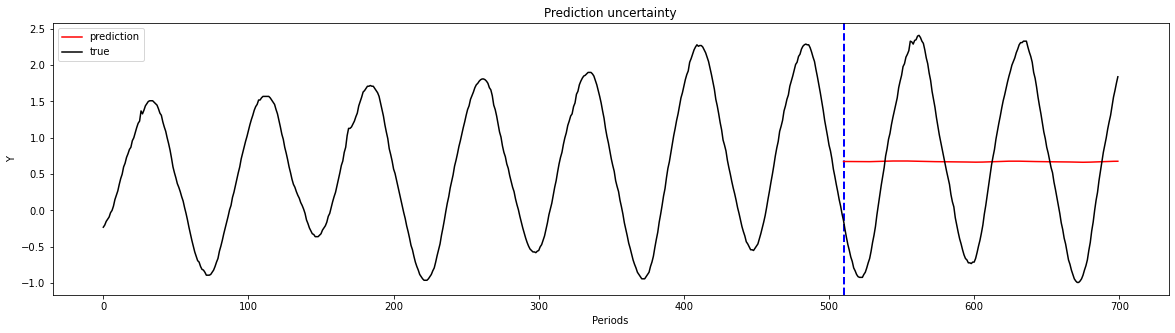

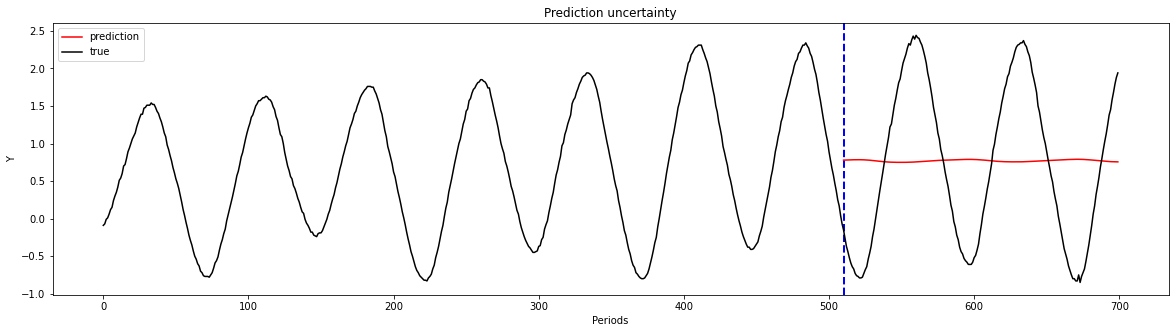

-----------------------------------------------------------------------------------------
| end of epoch  10 | time: 37.62s | valid loss 0.15991 | valid ppl     1.17
-----------------------------------------------------------------------------------------


/Users/jimengshi/opt/anaconda3/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  11 |    21/  108 batches | lr 0.000040 | 307.50 ms | loss 0.18023 | ppl     1.20
| epoch  11 |    42/  108 batches | lr 0.000040 | 302.67 ms | loss 0.10182 | ppl     1.11
| epoch  11 |    63/  108 batches | lr 0.000040 | 327.03 ms | loss 0.09887 | ppl     1.10
| epoch  11 |    84/  108 batches | lr 0.000040 | 331.49 ms | loss 0.11826 | ppl     1.13
| epoch  11 |   105/  108 batches | lr 0.000040 | 294.13 ms | loss 0.15592 | ppl     1.17
torch.Size([5, 787, 10]) torch.Size([5, 787, 10])
-----------------------------------------------------------------------------------------
| end of epoch  11 | time: 37.21s | valid loss 0.14843 | valid ppl     1.16
-----------------------------------------------------------------------------------------
| epoch  12 |    21/  108 batches | lr 0.000039 | 305.59 ms | loss 0.16723 | ppl     1.18
| epoch  12 |    42/  108 batches | lr 0.000039 | 320.86 ms | loss 0.09201 | ppl     1.10
| epoch  12 |    63/  108 batches | lr 0.000039 | 357.57 ms | lo

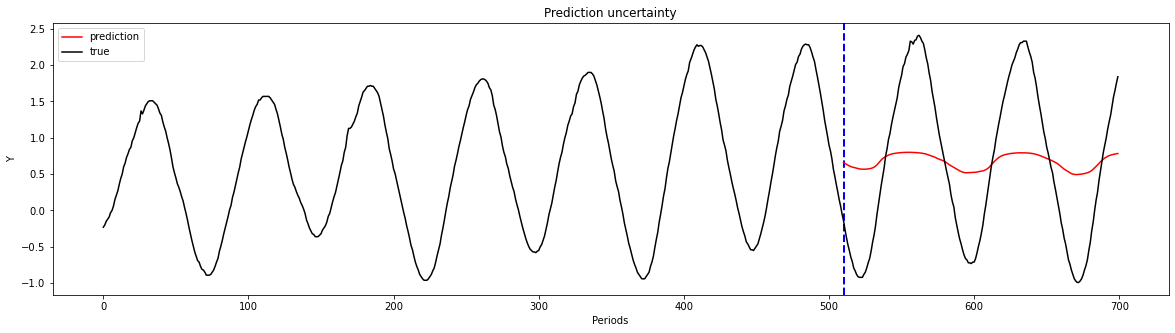

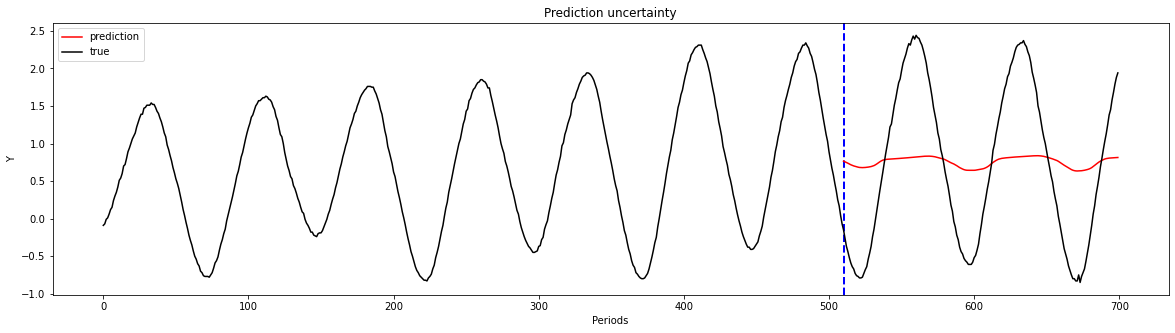

-----------------------------------------------------------------------------------------
| end of epoch  20 | time: 40.36s | valid loss 0.10101 | valid ppl     1.11
-----------------------------------------------------------------------------------------


/Users/jimengshi/opt/anaconda3/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  21 |    21/  108 batches | lr 0.000033 | 300.29 ms | loss 0.11179 | ppl     1.12
| epoch  21 |    42/  108 batches | lr 0.000033 | 307.16 ms | loss 0.05407 | ppl     1.06
| epoch  21 |    63/  108 batches | lr 0.000033 | 318.70 ms | loss 0.05215 | ppl     1.05
| epoch  21 |    84/  108 batches | lr 0.000033 | 304.06 ms | loss 0.06695 | ppl     1.07
| epoch  21 |   105/  108 batches | lr 0.000033 | 287.12 ms | loss 0.11708 | ppl     1.12
torch.Size([5, 787, 10]) torch.Size([5, 787, 10])
-----------------------------------------------------------------------------------------
| end of epoch  21 | time: 36.05s | valid loss 0.09737 | valid ppl     1.10
-----------------------------------------------------------------------------------------
| epoch  22 |    21/  108 batches | lr 0.000032 | 304.24 ms | loss 0.10793 | ppl     1.11
| epoch  22 |    42/  108 batches | lr 0.000032 | 285.66 ms | loss 0.05158 | ppl     1.05
| epoch  22 |    63/  108 batches | lr 0.000032 | 283.43 ms | lo

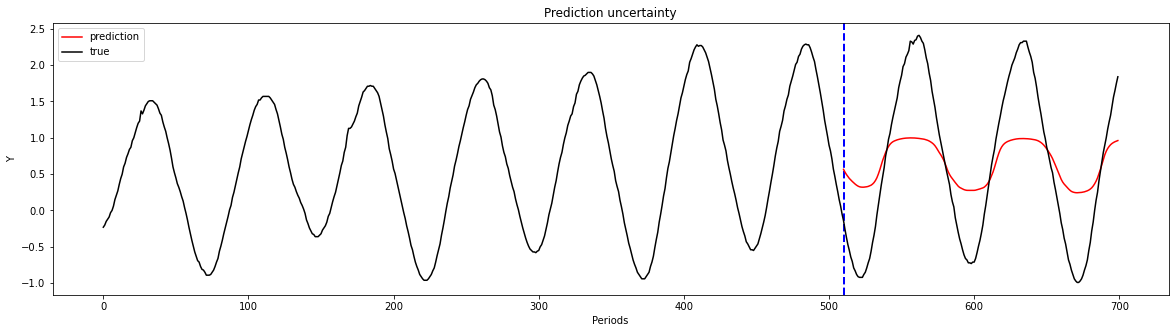

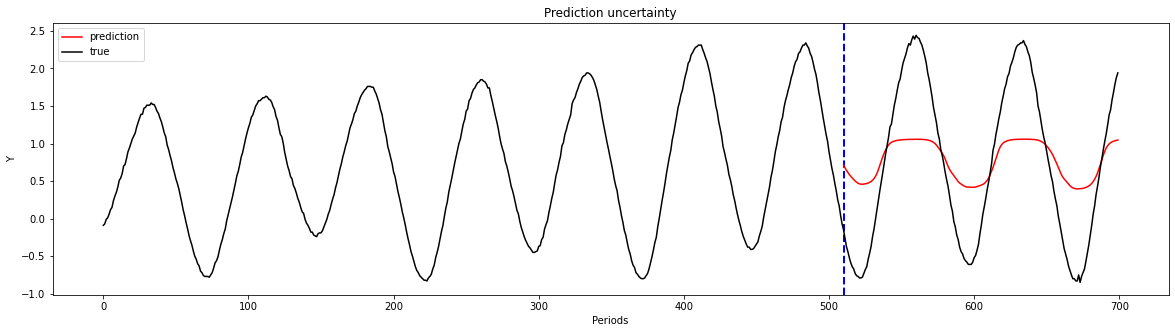

-----------------------------------------------------------------------------------------
| end of epoch  30 | time: 34.86s | valid loss 0.07038 | valid ppl     1.07
-----------------------------------------------------------------------------------------


/Users/jimengshi/opt/anaconda3/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  31 |    21/  108 batches | lr 0.000027 | 297.04 ms | loss 0.08291 | ppl     1.09
| epoch  31 |    42/  108 batches | lr 0.000027 | 282.96 ms | loss 0.03737 | ppl     1.04
| epoch  31 |    63/  108 batches | lr 0.000027 | 287.53 ms | loss 0.03504 | ppl     1.04
| epoch  31 |    84/  108 batches | lr 0.000027 | 282.50 ms | loss 0.04780 | ppl     1.05
| epoch  31 |   105/  108 batches | lr 0.000027 | 280.91 ms | loss 0.09618 | ppl     1.10
torch.Size([5, 787, 10]) torch.Size([5, 787, 10])
-----------------------------------------------------------------------------------------
| end of epoch  31 | time: 33.99s | valid loss 0.06779 | valid ppl     1.07
-----------------------------------------------------------------------------------------
| epoch  32 |    21/  108 batches | lr 0.000026 | 298.96 ms | loss 0.08002 | ppl     1.08
| epoch  32 |    42/  108 batches | lr 0.000026 | 283.73 ms | loss 0.03628 | ppl     1.04
| epoch  32 |    63/  108 batches | lr 0.000026 | 282.46 ms | lo

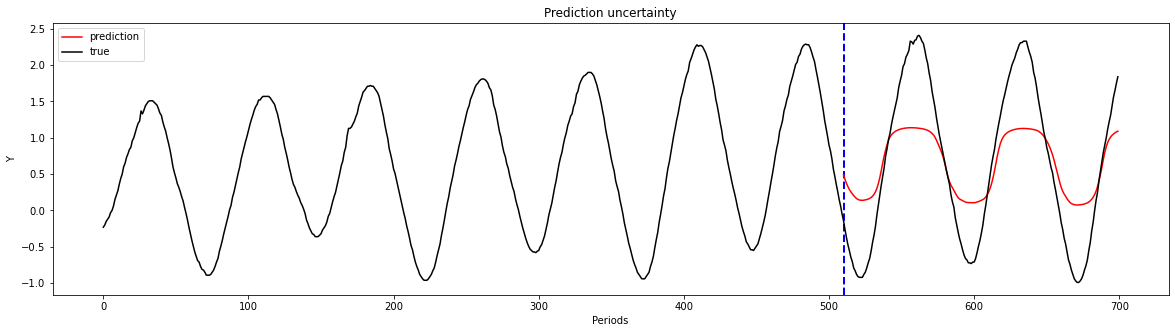

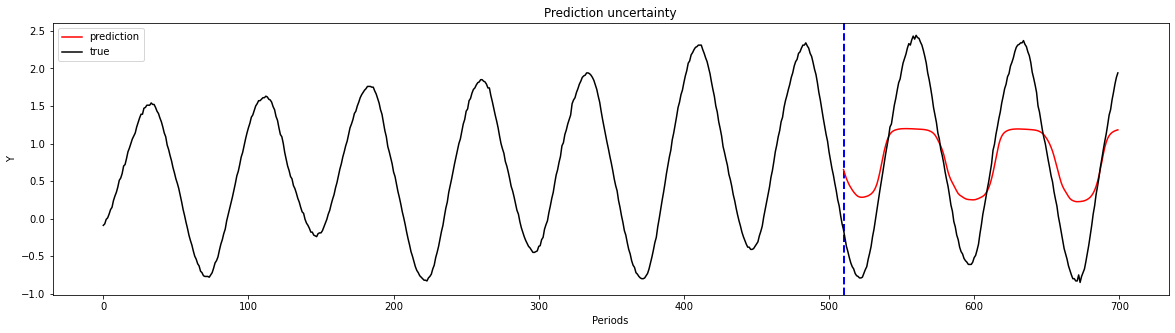

-----------------------------------------------------------------------------------------
| end of epoch  40 | time: 34.97s | valid loss 0.05253 | valid ppl     1.05
-----------------------------------------------------------------------------------------


/Users/jimengshi/opt/anaconda3/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  41 |    21/  108 batches | lr 0.000022 | 298.48 ms | loss 0.06522 | ppl     1.07
| epoch  41 |    42/  108 batches | lr 0.000022 | 283.89 ms | loss 0.02972 | ppl     1.03
| epoch  41 |    63/  108 batches | lr 0.000022 | 290.98 ms | loss 0.02567 | ppl     1.03
| epoch  41 |    84/  108 batches | lr 0.000022 | 285.46 ms | loss 0.03765 | ppl     1.04
| epoch  41 |   105/  108 batches | lr 0.000022 | 282.52 ms | loss 0.08047 | ppl     1.08
torch.Size([5, 787, 10]) torch.Size([5, 787, 10])
-----------------------------------------------------------------------------------------
| end of epoch  41 | time: 34.33s | valid loss 0.05108 | valid ppl     1.05
-----------------------------------------------------------------------------------------
| epoch  42 |    21/  108 batches | lr 0.000021 | 297.18 ms | loss 0.06364 | ppl     1.07
| epoch  42 |    42/  108 batches | lr 0.000021 | 283.19 ms | loss 0.02883 | ppl     1.03
| epoch  42 |    63/  108 batches | lr 0.000021 | 295.40 ms | lo

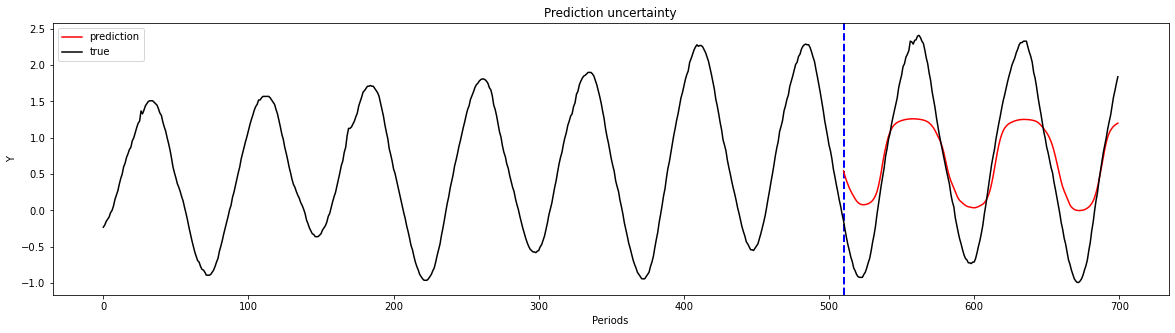

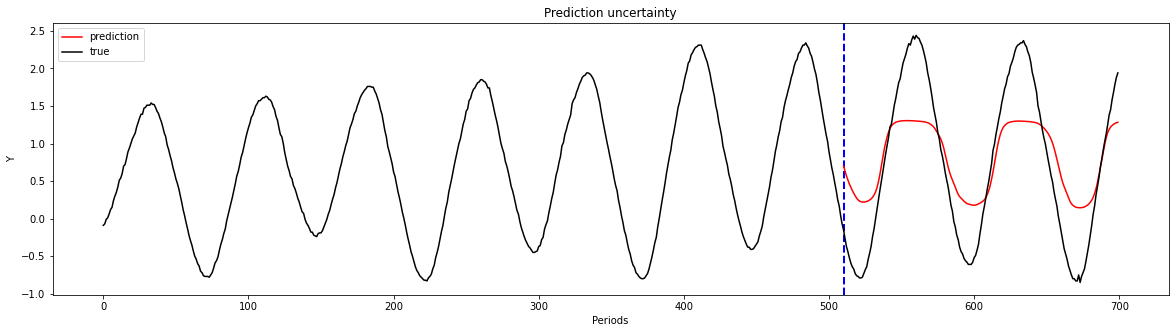

-----------------------------------------------------------------------------------------
| end of epoch  50 | time: 35.06s | valid loss 0.04480 | valid ppl     1.05
-----------------------------------------------------------------------------------------


/Users/jimengshi/opt/anaconda3/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  51 |    21/  108 batches | lr 0.000018 | 339.38 ms | loss 0.05188 | ppl     1.05
| epoch  51 |    42/  108 batches | lr 0.000018 | 296.70 ms | loss 0.02484 | ppl     1.03
| epoch  51 |    63/  108 batches | lr 0.000018 | 287.55 ms | loss 0.02161 | ppl     1.02
| epoch  51 |    84/  108 batches | lr 0.000018 | 282.77 ms | loss 0.03207 | ppl     1.03
| epoch  51 |   105/  108 batches | lr 0.000018 | 289.89 ms | loss 0.07043 | ppl     1.07
torch.Size([5, 787, 10]) torch.Size([5, 787, 10])
-----------------------------------------------------------------------------------------
| end of epoch  51 | time: 35.51s | valid loss 0.04383 | valid ppl     1.04
-----------------------------------------------------------------------------------------
| epoch  52 |    21/  108 batches | lr 0.000017 | 310.55 ms | loss 0.05082 | ppl     1.05
| epoch  52 |    42/  108 batches | lr 0.000017 | 287.33 ms | loss 0.02389 | ppl     1.02
| epoch  52 |    63/  108 batches | lr 0.000017 | 289.08 ms | lo

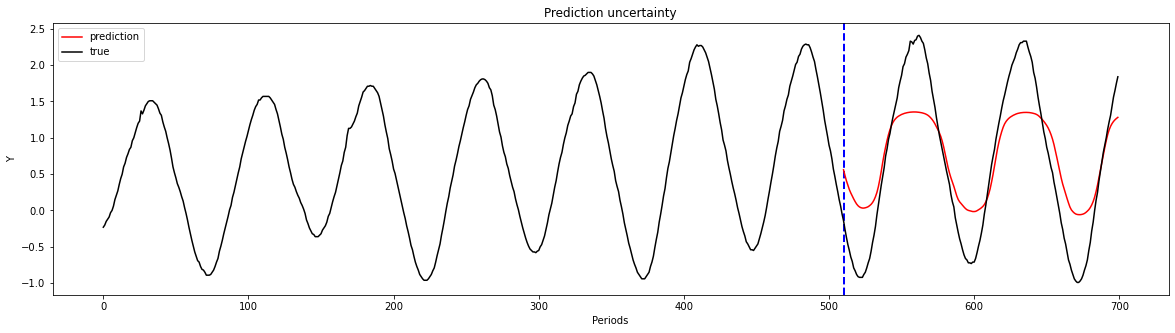

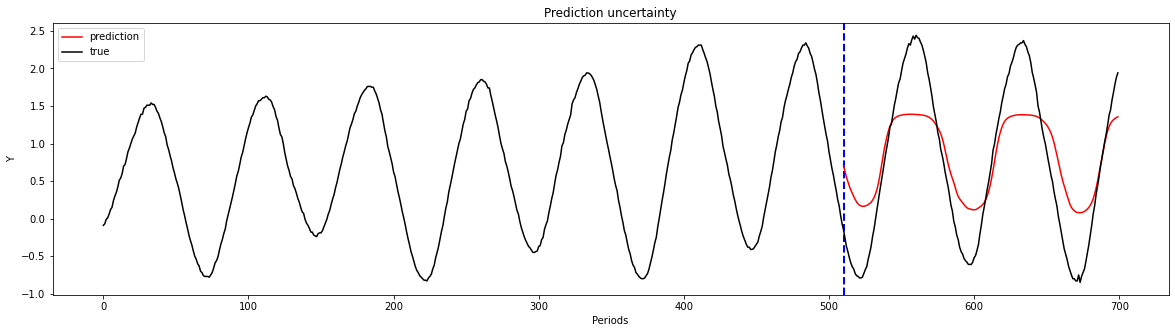

-----------------------------------------------------------------------------------------
| end of epoch  60 | time: 43.65s | valid loss 0.03986 | valid ppl     1.04
-----------------------------------------------------------------------------------------


/Users/jimengshi/opt/anaconda3/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  61 |    21/  108 batches | lr 0.000015 | 382.40 ms | loss 0.04407 | ppl     1.05
| epoch  61 |    42/  108 batches | lr 0.000015 | 303.75 ms | loss 0.02083 | ppl     1.02
| epoch  61 |    63/  108 batches | lr 0.000015 | 287.35 ms | loss 0.01907 | ppl     1.02
| epoch  61 |    84/  108 batches | lr 0.000015 | 286.98 ms | loss 0.02878 | ppl     1.03
| epoch  61 |   105/  108 batches | lr 0.000015 | 285.38 ms | loss 0.06310 | ppl     1.07
torch.Size([5, 787, 10]) torch.Size([5, 787, 10])
-----------------------------------------------------------------------------------------
| end of epoch  61 | time: 36.53s | valid loss 0.03936 | valid ppl     1.04
-----------------------------------------------------------------------------------------
| epoch  62 |    21/  108 batches | lr 0.000014 | 304.41 ms | loss 0.04485 | ppl     1.05
| epoch  62 |    42/  108 batches | lr 0.000014 | 296.31 ms | loss 0.02050 | ppl     1.02
| epoch  62 |    63/  108 batches | lr 0.000014 | 312.04 ms | lo

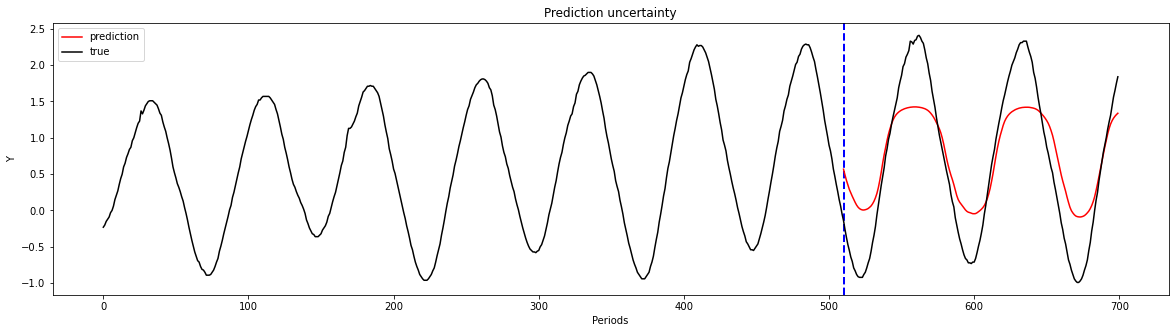

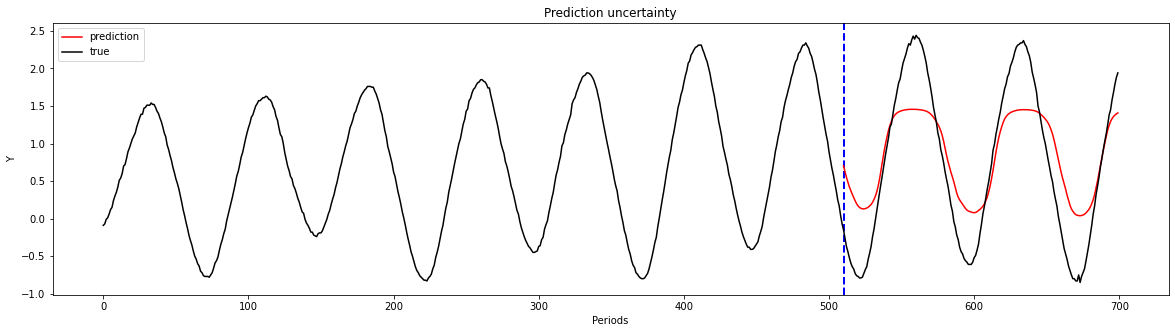

-----------------------------------------------------------------------------------------
| end of epoch  70 | time: 42.49s | valid loss 0.03678 | valid ppl     1.04
-----------------------------------------------------------------------------------------


/Users/jimengshi/opt/anaconda3/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch  71 |    21/  108 batches | lr 0.000012 | 373.63 ms | loss 0.03934 | ppl     1.04
| epoch  71 |    42/  108 batches | lr 0.000012 | 298.87 ms | loss 0.01871 | ppl     1.02
| epoch  71 |    63/  108 batches | lr 0.000012 | 321.99 ms | loss 0.01787 | ppl     1.02
| epoch  71 |    84/  108 batches | lr 0.000012 | 389.66 ms | loss 0.02684 | ppl     1.03
| epoch  71 |   105/  108 batches | lr 0.000012 | 411.99 ms | loss 0.05967 | ppl     1.06
torch.Size([5, 787, 10]) torch.Size([5, 787, 10])
-----------------------------------------------------------------------------------------
| end of epoch  71 | time: 43.89s | valid loss 0.03653 | valid ppl     1.04
-----------------------------------------------------------------------------------------
| epoch  72 |    21/  108 batches | lr 0.000012 | 353.59 ms | loss 0.03900 | ppl     1.04
| epoch  72 |    42/  108 batches | lr 0.000012 | 378.91 ms | loss 0.01816 | ppl     1.02
| epoch  72 |    63/  108 batches | lr 0.000012 | 363.19 ms | lo

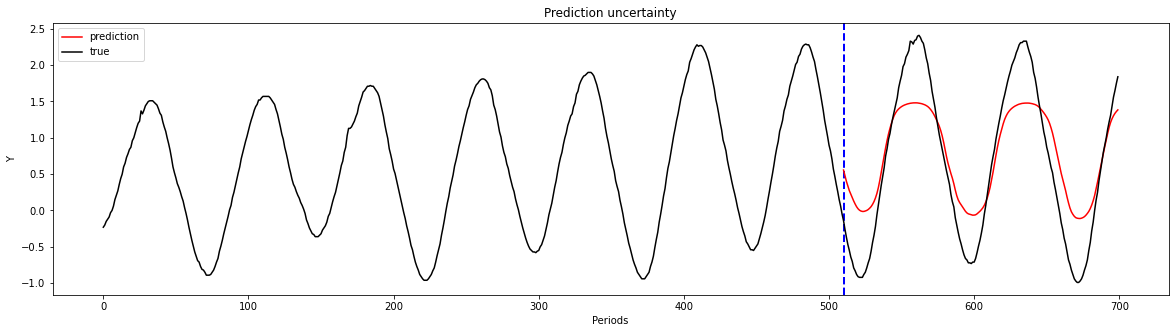

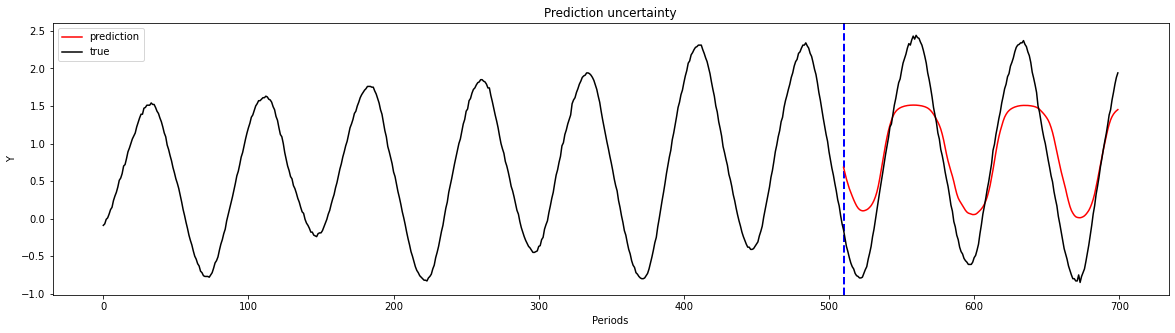

-----------------------------------------------------------------------------------------
| end of epoch  80 | time: 33.84s | valid loss 0.03453 | valid ppl     1.04
-----------------------------------------------------------------------------------------


In [17]:
train_data, val_data,scaler = get_data()
model = TransAm().to(device)

criterion = nn.MSELoss()
lr = 0.00005 
#optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.98)

best_val_loss = float("inf")
epochs = 80 # The number of epochs
best_model = None

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train(train_data)
    
    
    if(epoch % 10 is 0):
        val_loss = plot(model, val_data,epoch,scaler)
        # predict_future(model, val_data,200,epoch,scaler)
    else:
        val_loss = evaluate(model, val_data)
        
    print('-' * 89)
    print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.5f} | valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
                                     val_loss, math.exp(val_loss)))
    print('-' * 89)

    #if val_loss < best_val_loss:
    #    best_val_loss = val_loss
    #    best_model = model

    scheduler.step() 